In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
import tensorflow as tf
from keras import optimizers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard,CSVLogger

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)


Using TensorFlow backend.
/home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/francovm/an

In [2]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [3]:
# load  dataset
df = pd.read_csv('/home/francovm/Projects/SSE/data/processed/input_data_shifted_40.csv', sep='\t', encoding='utf-8', index_col=0)


In [4]:
input_X = df.loc[:, df.columns != 'Events'].values  # converts the df to a numpy array
input_y = df['Events'].values

n_features = input_X.shape[1]  # number of features

print(input_X.shape,input_y.shape)

(219861, 3) (219861,)


# Temporalize data

In [5]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y


In [6]:
# Temporalize the data

lookback = 20
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)



# Split into Test, valid and train

In [7]:
#Split into Test, valid and train

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

## Separate negatives and positives values

In [8]:
X_train_y0 = X_train[y_train==0.]
X_train_y1 = X_train[y_train==1.]

X_valid_y0 = X_valid[y_valid==0.]
X_valid_y1 = X_valid[y_valid==1.]

In [9]:
# Reshape the arrays

X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [10]:
y_train.shape

(140697,)

In [11]:
## To Categorical Data

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_valid = to_categorical(y_valid)

# print(y_valid.shape, y_test.shape, y_train.shape)

In [12]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
print(n_timesteps,n_features,n_outputs)

20 3 1


# Stardarization

In [13]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [14]:
# Initialize a scaler using the training data.
# scaler = StandardScaler().fit(flatten(X_train))

In [15]:
# Standarize the input

# X_train_scaled = scale(X_train, scaler)
# X_valid_scaled = scale(X_valid, scaler)
# X_test_scaled = scale(X_test, scaler)

### Test Standarization

In [16]:
# a = flatten(X_train_scaled)
# print('colwise mean', np.mean(a,axis=0).round(6))
# print('colwise variance', np.var(a, axis=0))



# Model training

Training models (Use it)


In [17]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(n_timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 32)            4608      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 16)            2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 32)            6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3)             99        
Total params: 16,227
Trainable params: 16,227
Non-trainable params: 0
_________________________________________________________________


In [18]:
lr = 0.0001
verbose, epochs, batch_size = 1, 100, 64

adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam, metrics=['accuracy'])

cp = ModelCheckpoint(filepath="/home/francovm/Projects/SSE/models/Autoencoder/Autoencoder-anomaly_LSTM_SSE_20window.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='/home/francovm/Projects/SSE/models/Autoencoder/Tensorboard/Autoencoder-anomaly_LSTM_SSE_20window',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

csv_logger = CSVLogger('/home/francovm/Projects/SSE/data/Visualization/Data/Autoencoder-anomaly_LSTM_SSE_20window.csv', append=True, separator=';')

#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=8)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0, X_train_y0, 
                                                epochs=epochs, 
                                                batch_size=batch_size, 
                                                callbacks=[early_stopping_monitor,cp,tb,csv_logger],
                                                validation_data=(X_valid_y0, X_valid_y0),
                                                verbose=verbose)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 136371 samples, validate on 34152 samples


Epoch 1/100
136371/136371 [==============================] - 384s 3ms/step - loss: 8347.4905 - acc: 0.5293 - val_loss: 4382.0240 - val_acc: 0.5361
Epoch 2/100
136371/136371 [==============================] - 378s 3ms/step - loss: 3808.9088 - acc: 0.6142 - val_loss: 3001.1101 - val_acc: 0.6624
Epoch 3/100
136371/136371 [==============================] - 377s 3ms/step - loss: 2576.7117 - acc: 0.6754 - val_loss: 2297.1526 - val_acc: 0.6972
Epoch 4/100
136371/136371 [==============================] - 378s 3ms/step - loss: 2184.6659 - acc: 0.7048 - val_loss: 2073.2773 - val_acc: 0.7049
Epoch 5/100
136371/136371 [==============================] - 376s 3ms/step - loss: 1981.2763 - acc: 0.7158 - val_loss: 1939.7662 - val_acc: 0.7178
Epoch 6/100
136371/136371 [==============================] - 373s 3ms/step - loss: 1816.9639 - acc: 0.7215 - val_lo

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


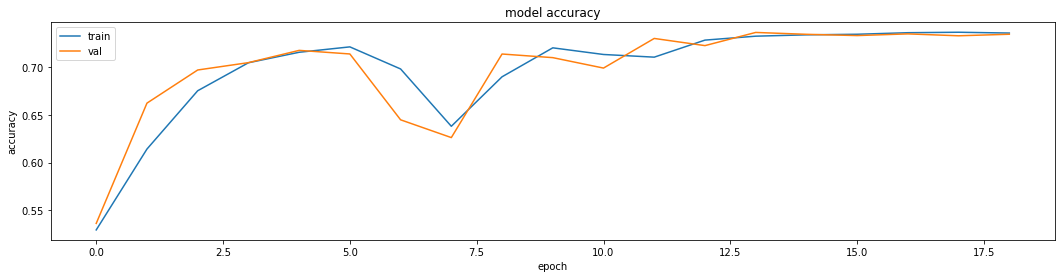

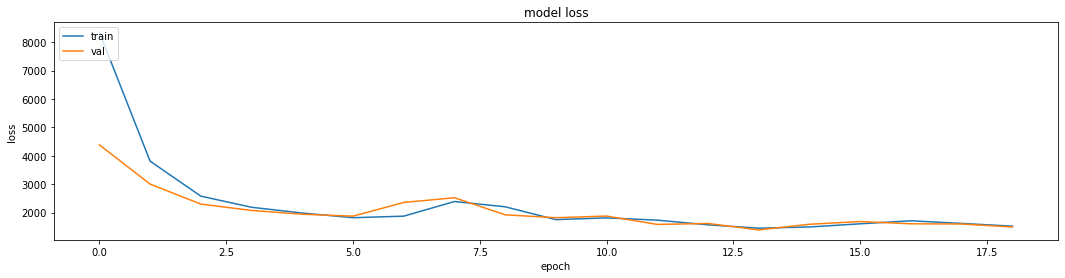

In [22]:
# list all data in history
print(lstm_autoencoder_history.history.keys())

# summarize history for accuracy
plt.plot(lstm_autoencoder_history.history['acc'])
plt.plot(lstm_autoencoder_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.savefig('/home/francovm/Projects/SSE/data/Visualization/Autoencoder-anomaly_LSTM_SSE_20window-acc.png')
plt.show()

# summarize history for loss
plt.plot(lstm_autoencoder_history.history['loss'])
plt.plot(lstm_autoencoder_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
 # Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.savefig('/home/francovm/Projects/SSE/data/Visualization/Autoencoder-anomaly_LSTM_SSE_20window-loss.png')
plt.show()

# Save Model

In [23]:
# save model and architecture to single file
# model.save("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_40days-shifted.h5")

# df = pd.DataFrame(lstm_autoencoder_history.history)

# df.to_csv( '/home/francovm/Projects/SSE/data/Visualization/Data/LSTM_SSE_20days_Autoencoder_Anomaly.csv',header=True)


# Sanity check

Doing a sanity check by validating the reconstruction error on the train data. Here we will reconstruct the entire train data with both 0 and 1 labels.

**Expectation**: the reconstruction error of 0 labeled data should be smaller than 1.

**Caution**: do not use this result for model evaluation. It may result into overfitting issues.

In [15]:
train_x_predictions = model.predict(X_train)

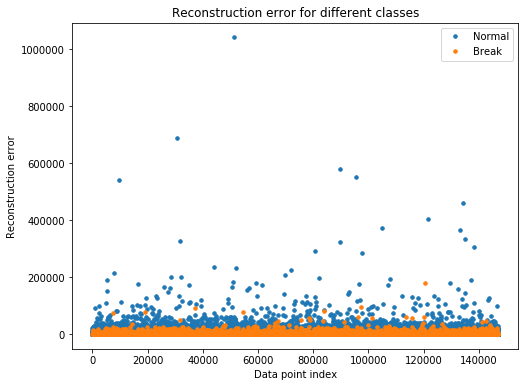

In [16]:
# train_x_predictions = lstm_autoencoder.predict(X_train)

mse = np.mean(np.power(flatten(X_train) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

# error_df = error_df.reset_index()
groups = error_df.groupby('True_class')

fig, ax = plt.subplots()

# print(np.reshape(group.index,140681,1), group.Reconstruction_error)
for name, group in groups:
    ax.plot(group.Reconstruction_error, marker='o', ms=3.5, linestyle='',label= "Break" if name == 1. else "Normal")

ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()



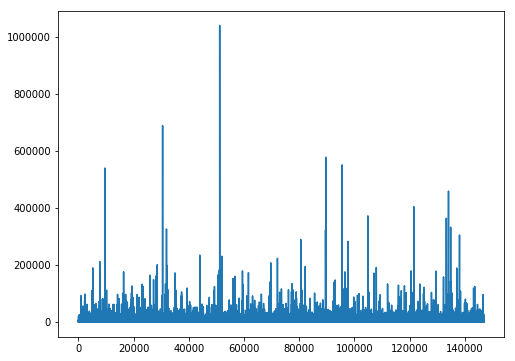

In [17]:
plt.plot(mse)

# Predictions using the Autoencoder

In [18]:
valid_x_predictions = model.predict(X_valid)

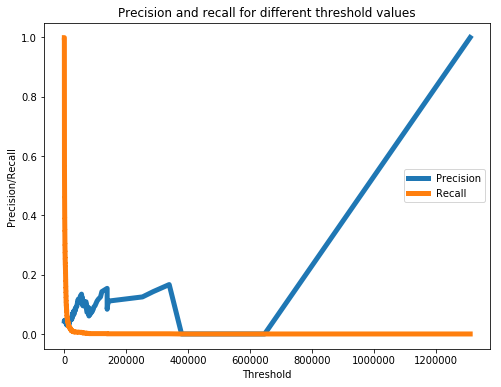

In [19]:
# valid_x_predictions = lstm_autoencoder.predict(X_valid)
mse = np.mean(np.power(flatten(X_valid) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# Threshold 

(0.0, 1000000)

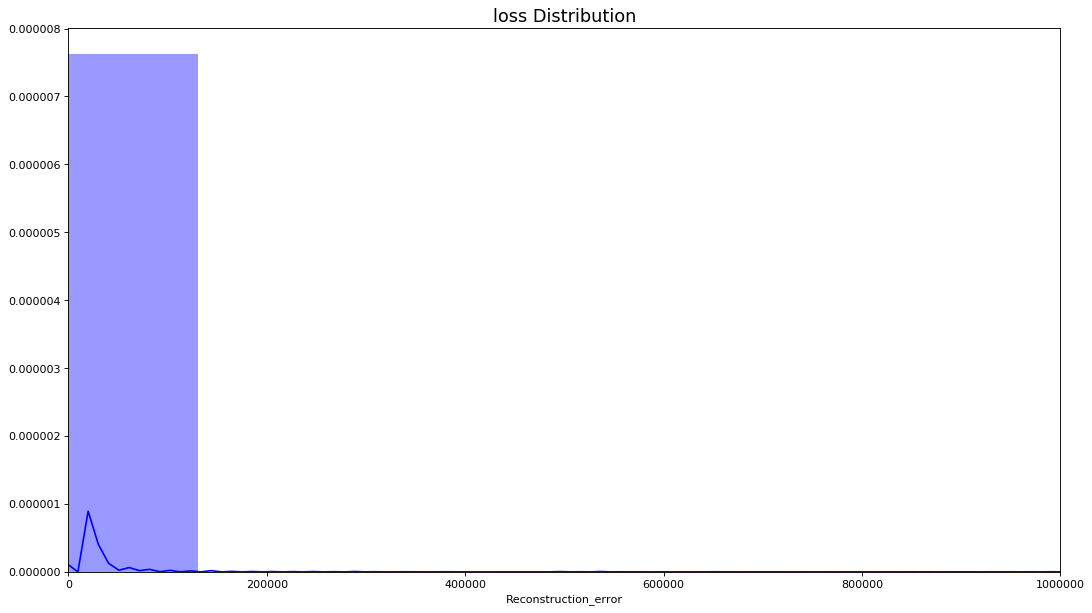

In [32]:
plt.figure(figsize=(16,9),dpi=80)
plt.title('loss Distribution', fontsize=16)
sns.distplot(error_df['Reconstruction_error'],bins=10,kde=True,color='blue');
plt.xlim([0.0,1000000])

# loop

In [44]:
threshold=0
f1=0
recall=0
accuracy=0
while (recall < 0.5 or accuracy < 0.6):
    print ('**************************')
    print (threshold)
#     threshold += .0005
    threshold += 1000
    y_pred = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    precision = 1. * tp / (tp + fp)
    recall = 1. * tp / (tp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
# print ('**************************')
# print (threshold)
    print ('TP:' + str(tp))
    print ('FP:' + str(fp))
    print ('TN:' + str(tn))
    print ('FN:' + str(fn))
    accuracy = 1. * (tp + tn) / (tp + tn + fp + fn)
    print ('Accuracy:' + str(accuracy))
    print ('Precision:' + str(precision))
    print ('Recall:' + str(recall))
    print ('F1:' + str(f1))


**************************
0
TP:746
FP:18266
TN:25751
FN:1176
Accuracy:0.5767866083284355
Precision:0.039238375762676206
Recall:0.3881373569198751
F1:0.0712716155536448
**************************
1000
TP:525
FP:13685
TN:30332
FN:1397
Accuracy:0.6716950739023487
Precision:0.03694581280788178
Recall:0.27315296566077
F1:0.06508802380362014
**************************
2000
TP:412
FP:10817
TN:33200
FN:1510
Accuracy:0.7316659047867825
Precision:0.03669071155044973
Recall:0.21436004162330904
F1:0.06265683218006235
**************************
3000
TP:342
FP:8571
TN:35446
FN:1580
Accuracy:0.779033065586974
Precision:0.038370918882531135
Recall:0.17793964620187305
F1:0.06312874942316567
**************************
4000
TP:262
FP:6947
TN:37070
FN:1660
Accuracy:0.8126428524782864
Precision:0.03634345956443335
Recall:0.13631633714880334
F1:0.05738692366663016
**************************
5000
TP:196
FP:5774
TN:38243
FN:1726
Accuracy:0.8367400248155162
Precision:0.03283082077051926
Recall:0.1019771071800

/home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


TP:0
FP:29
TN:43988
FN:1922
Accuracy:0.9575306384553429
Precision:0.0
Recall:0.0
F1:nan
**************************
98000
TP:0
FP:28
TN:43989
FN:1922
Accuracy:0.9575524064520342
Precision:0.0
Recall:0.0
F1:nan
**************************
99000
TP:0
FP:28
TN:43989
FN:1922
Accuracy:0.9575524064520342
Precision:0.0
Recall:0.0
F1:nan
**************************
100000
TP:0
FP:27
TN:43990
FN:1922
Accuracy:0.9575741744487255
Precision:0.0
Recall:0.0
F1:nan
**************************
101000
TP:0
FP:27
TN:43990
FN:1922
Accuracy:0.9575741744487255
Precision:0.0
Recall:0.0
F1:nan
**************************
102000
TP:0
FP:27
TN:43990
FN:1922
Accuracy:0.9575741744487255
Precision:0.0
Recall:0.0
F1:nan
**************************
103000
TP:0
FP:27
TN:43990
FN:1922
Accuracy:0.9575741744487255
Precision:0.0
Recall:0.0
F1:nan
**************************
104000
TP:0
FP:27
TN:43990
FN:1922
Accuracy:0.9575741744487255
Precision:0.0
Recall:0.0
F1:nan
**************************
105000
TP:0
FP:27
TN:43990
FN:192

KeyboardInterrupt: 

In [38]:
test_x_predictions = model.predict(X_test)

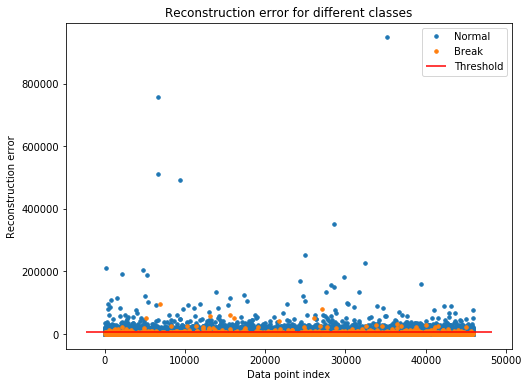

In [45]:
# test_x_predictions = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(flatten(X_test) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 5000 # Definir!
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot( group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [46]:
pred_y = [1. if e > threshold_fixed else 0. for e in error_df.Reconstruction_error.values]

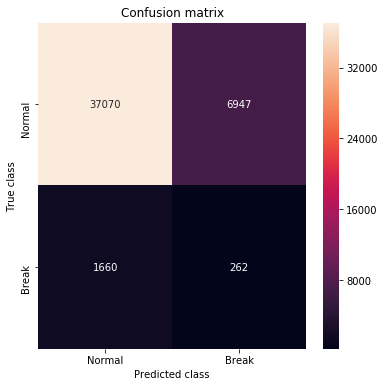

In [47]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

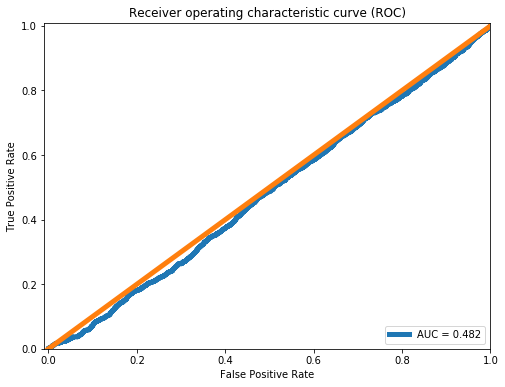

In [48]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()